In [3]:
%cd ..

/pub/hofmann-scratch/glanzillo/ded


In [4]:

import json
import math
import os
import socket
import sys
import time
import datetime
import uuid
from argparse import ArgumentParser
import setproctitle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from matplotlib.collections import LineCollection
import json

internal_path = os.path.abspath(os.path.join('.'))
sys.path.append(internal_path)
sys.path.append(internal_path + '/datasets')
sys.path.append(internal_path + '/utils')

import shutil
from utils.args import add_management_args, add_rehearsal_args
from utils.conf import set_random_seed, get_device, base_path
from utils.status import ProgressBar
from utils.stil_losses import *
from utils.nets import *
from utils.eval import evaluate, validation_and_agreement, distance_models, evaluate_regression


from sklearn.datasets import *
from sklearn import linear_model



/local/home/glanzillo/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Evaluating the distribution of |f(x)-t(x)| 

In [45]:
from utils.conf import set_random_seed, get_device, base_path
from utils.status import ProgressBar
from torch.utils.data import ConcatDataset

DEVICE=[4]
CHKPT_NAME = "rn50_2023-02-21_10-45-30_best.ckpt"

device = get_device(DEVICE)
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=",".join([str(d) for d in DEVICE])



In [46]:
def load_checkpoint(device, best=False, filename='checkpoint.pth.tar', distributed=False):
    path = base_path() + "chkpts" + "/" + "imagenet" + "/" + "resnet50/"
    if best: filepath = path + 'model_best.pth.tar'
    else: filepath = path + filename
    if os.path.exists(filepath):
          print(f"Loading existing checkpoint {filepath}")
          checkpoint = torch.load(filepath, map_location=device)
          if filename==CHKPT_NAME and not distributed: # modify Sidak's checkpoint
                new_state_dict = {k.replace('module.','',1):v for (k,v) in checkpoint['state_dict'].items()}
                checkpoint['state_dict'] = new_state_dict
          return checkpoint
    return None 

In [47]:
imagenet_root = "/local/home/stuff/imagenet/"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


train_transform = transforms.Compose([
                            transforms.RandomResizedCrop(224),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            normalize,
                        ])
inference_transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize,
                ])

train_dataset = ImageFolder(imagenet_root+'train', train_transform)
val_dataset = ImageFolder(imagenet_root+'val', inference_transform)

In [6]:
all_data = ConcatDataset([train_dataset, val_dataset])
all_data_loader = DataLoader(all_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

In [11]:
# loading the teacher
teacher = resnet50(weights=None)
checkpoint = load_checkpoint(device, best=False, filename=CHKPT_NAME, distributed=False) 
teacher.load_state_dict(checkpoint['state_dict'])
teacher.to(device)
teacher.eval();

Loading existing checkpoint ./logs/chkpts/imagenet/resnet50/rn50_2023-02-21_10-45-30_best.ckpt


In [14]:
SEEDS = [11,13,21, 33]
BUFFER_SIZES = [30000]#[48
ALPHA = [0.0,1.0]

In [16]:
seed = 11
buffer_size=30000
alpha=0.0
STUD_CHKPT = f'rn50-student-{seed}-{buffer_size}-{alpha}.ckpt'
# loading the student
student = resnet50(weights=None)
checkpoint = load_checkpoint(device, best=False, filename=STUD_CHKPT, distributed=False) 
student.load_state_dict(checkpoint['state_dict'])
student.to(device)
student.eval();

Loading  rn50-student-11-30000-0.0.ckpt
Loading existing checkpoint ./logs/chkpts/imagenet/resnet50/rn50-student-11-30000-0.0.ckpt


In [27]:
path = base_path() + "results" + "/" + "imagenet" + "/" + "resnet50" 

In [ ]:

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)
progress_bar = ProgressBar(verbose=True)
for seed in SEEDS: 
        buffer_size=30000
        alpha=0.0
        STUD_CHKPT = f'rn50-student-{seed}-{buffer_size}-{alpha}.ckpt'
        # loading the student
        student = resnet50(weights=None)
        checkpoint = load_checkpoint(device, best=False, filename=STUD_CHKPT, distributed=False) 
        student.load_state_dict(checkpoint['state_dict'])
        student.to(device)
        student.eval();
        for i,data in enumerate(train_loader):
                with torch.no_grad():
                        inputs, labels = data
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs_s = F.softmax(student(inputs),dim=1)
                        outputs_t = F.softmax(teacher(inputs),dim=1)
                        distance = torch.norm(outputs_s-outputs_t, dim=1, p=2).tolist()
                progress_bar.prog(i, len(train_loader)*len(SEEDS), 0, 'all-data', -1)
                distance_log = {}
                distance_log['alpha'] = alpha
                distance_log['batch'] = i
                distance_log['buffer_size'] = buffer_size
                distance_log['seed'] = seed 
                for d in distance: 
                        dict = distance_log
                        dict['distance'] = d
                        with open(path+ "/FDIST.txt", 'a') as f:
                                f.write(json.dumps(dict) + '\n')


128

# Looking at the results

In [48]:
logs_path = './logs/results/imagenet/resnet50/FDIST_test.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))
res_df = pd.DataFrame(results)
res_df

,alpha,batch,buffer_size,seed,test,teacher,distance
0,0.0,0,30000,13,True,True,0.826287
1,0.0,0,30000,13,True,False,0.836309
2,0.0,0,30000,13,True,True,0.327722
3,0.0,0,30000,13,True,False,0.837742
4,0.0,0,30000,13,True,True,0.492724
...,...,...,...,...,...,...,...
364768,1.0,253,30000,21,True,True,1.265410
364769,1.0,253,30000,21,True,False,1.265516
364770,1.0,253,30000,21,True,True,0.926303
364771,1.0,253,30000,21,True,False,1.060663


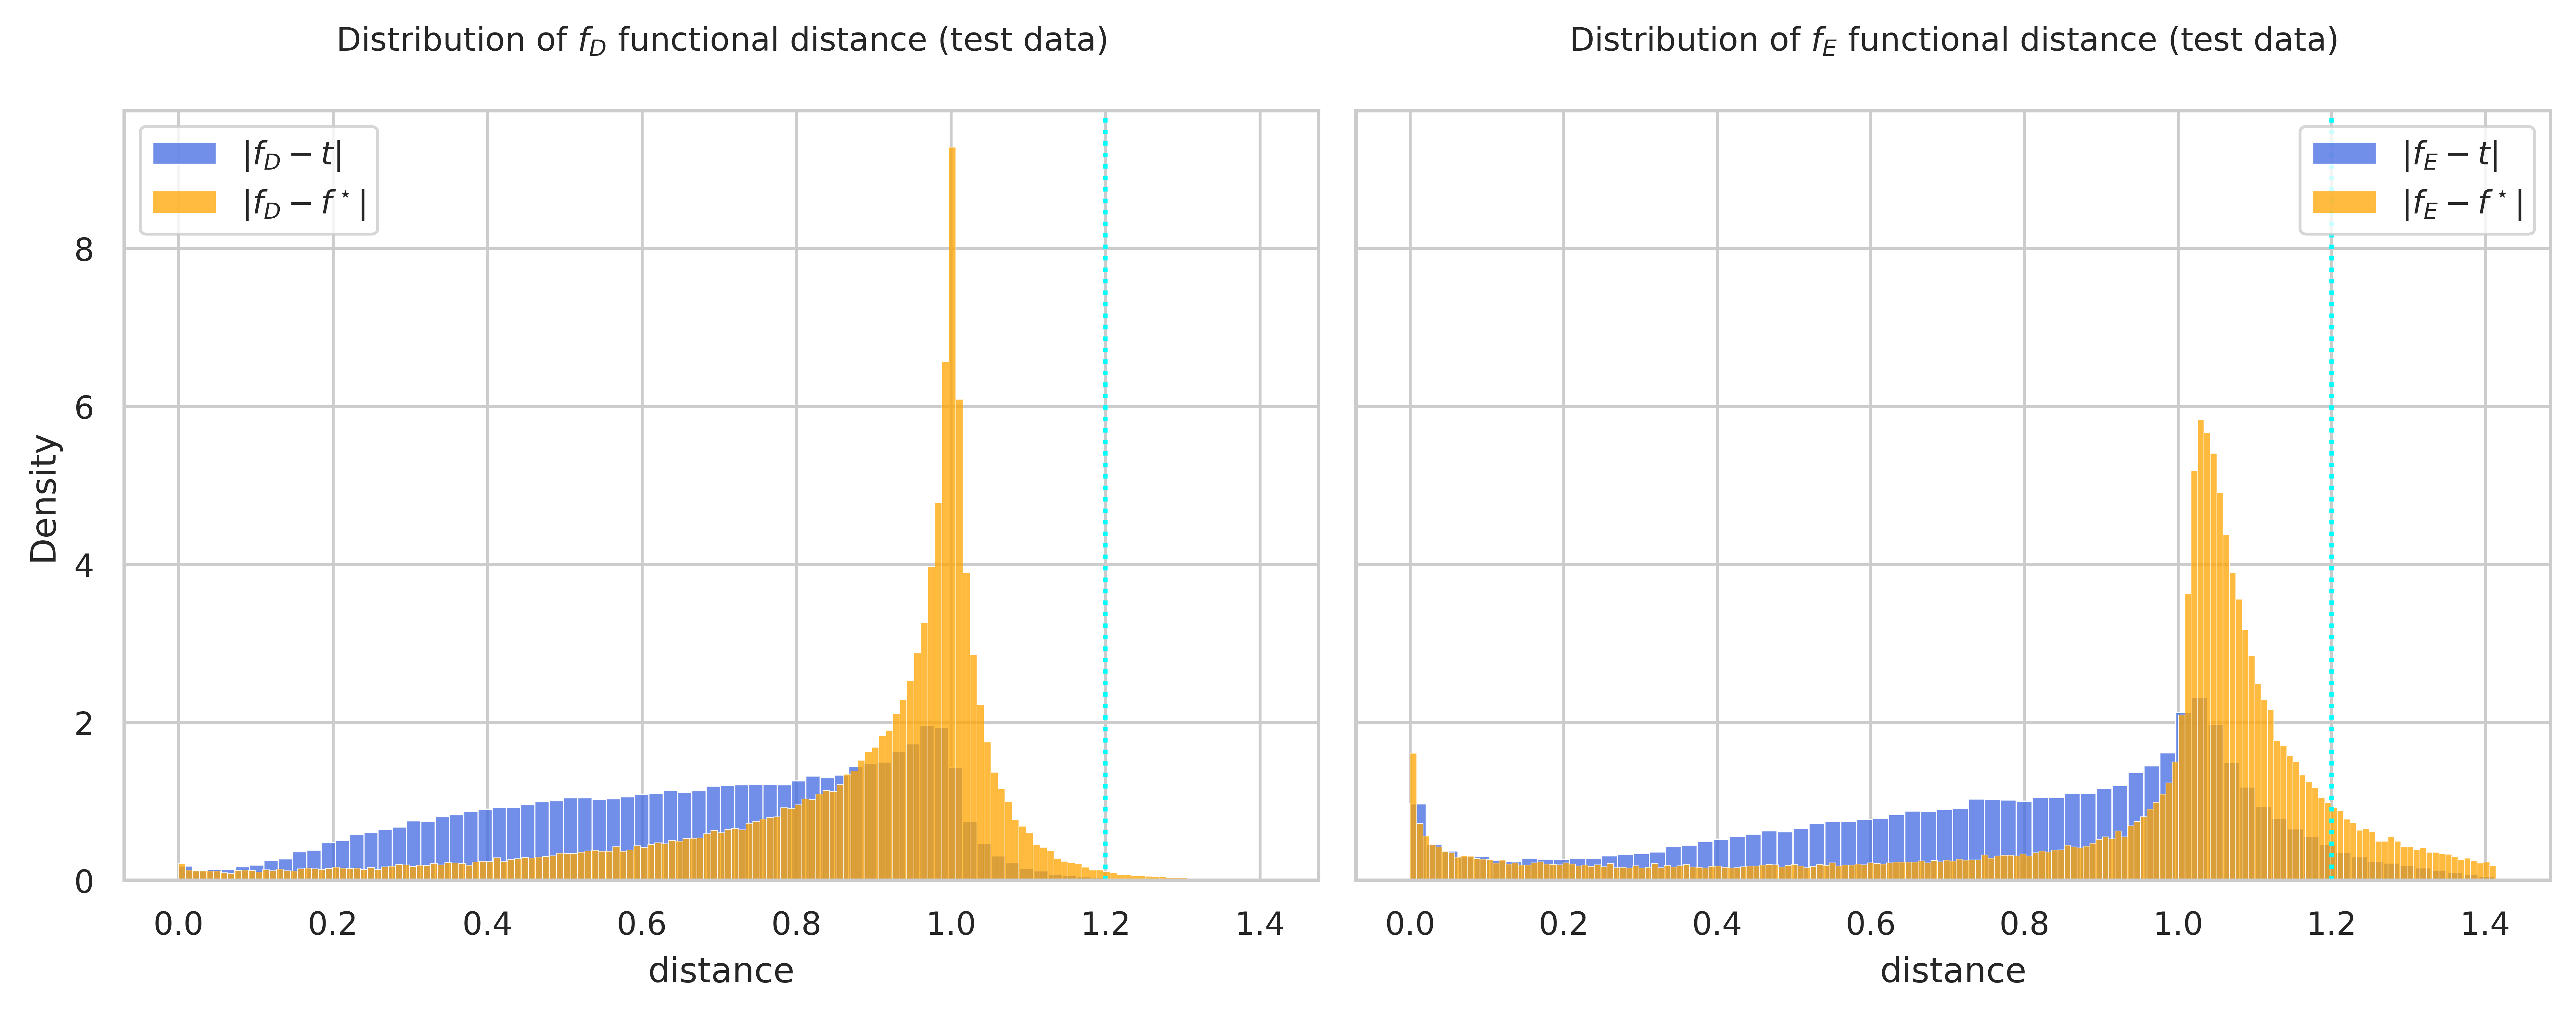

In [55]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']

    # first plot ---------------------------
    _df = res_df.loc[res_df['alpha']==0]

    _df1 = _df.loc[_df['teacher']==True]
    sns.histplot(_df1, x="distance", ax=ax[0], color=colors[0], label="train", stat="density")
    
    _df2 = _df.loc[_df['teacher']==False]
    sns.histplot(_df2, x="distance", ax=ax[0], color=colors[1], label="test", stat="density")

    ax[0].axvline(1.20, ls=':', color='aqua')


    ax[0].set_title(r"Distribution of $f_D$ functional distance (test data)", fontsize=9, y=1.05)
    

    # second plot ---------------------------
    _df = res_df.loc[res_df['alpha']==1]

    _df1 = _df.loc[_df['teacher']==True]
    sns.histplot(_df1, x="distance", ax=ax[1], color=colors[0], label="train", stat="density")
    
    _df2 = _df.loc[_df['teacher']==False]
    sns.histplot(_df2, x="distance", ax=ax[1], color=colors[1], label="test", stat="density")

    ax[1].axvline(1.20, ls=':', color='aqua')
    ax[1].set_title(r"Distribution of $f_E$ functional distance (test data)", fontsize=9, y=1.05)
    

    # refinements ---------------------------
    h, _ = ax[0].get_legend_handles_labels()
    ax[0].legend(h, [r'$|f_D - t|$',r'$|f_D - f^\star|$'], title="", ncol=1, loc="upper left")
    ax[1].legend(h, [r'$|f_E - t|$',r'$|f_E - f^\star|$'], title="", ncol=1, loc="upper right")

    plt.tight_layout()


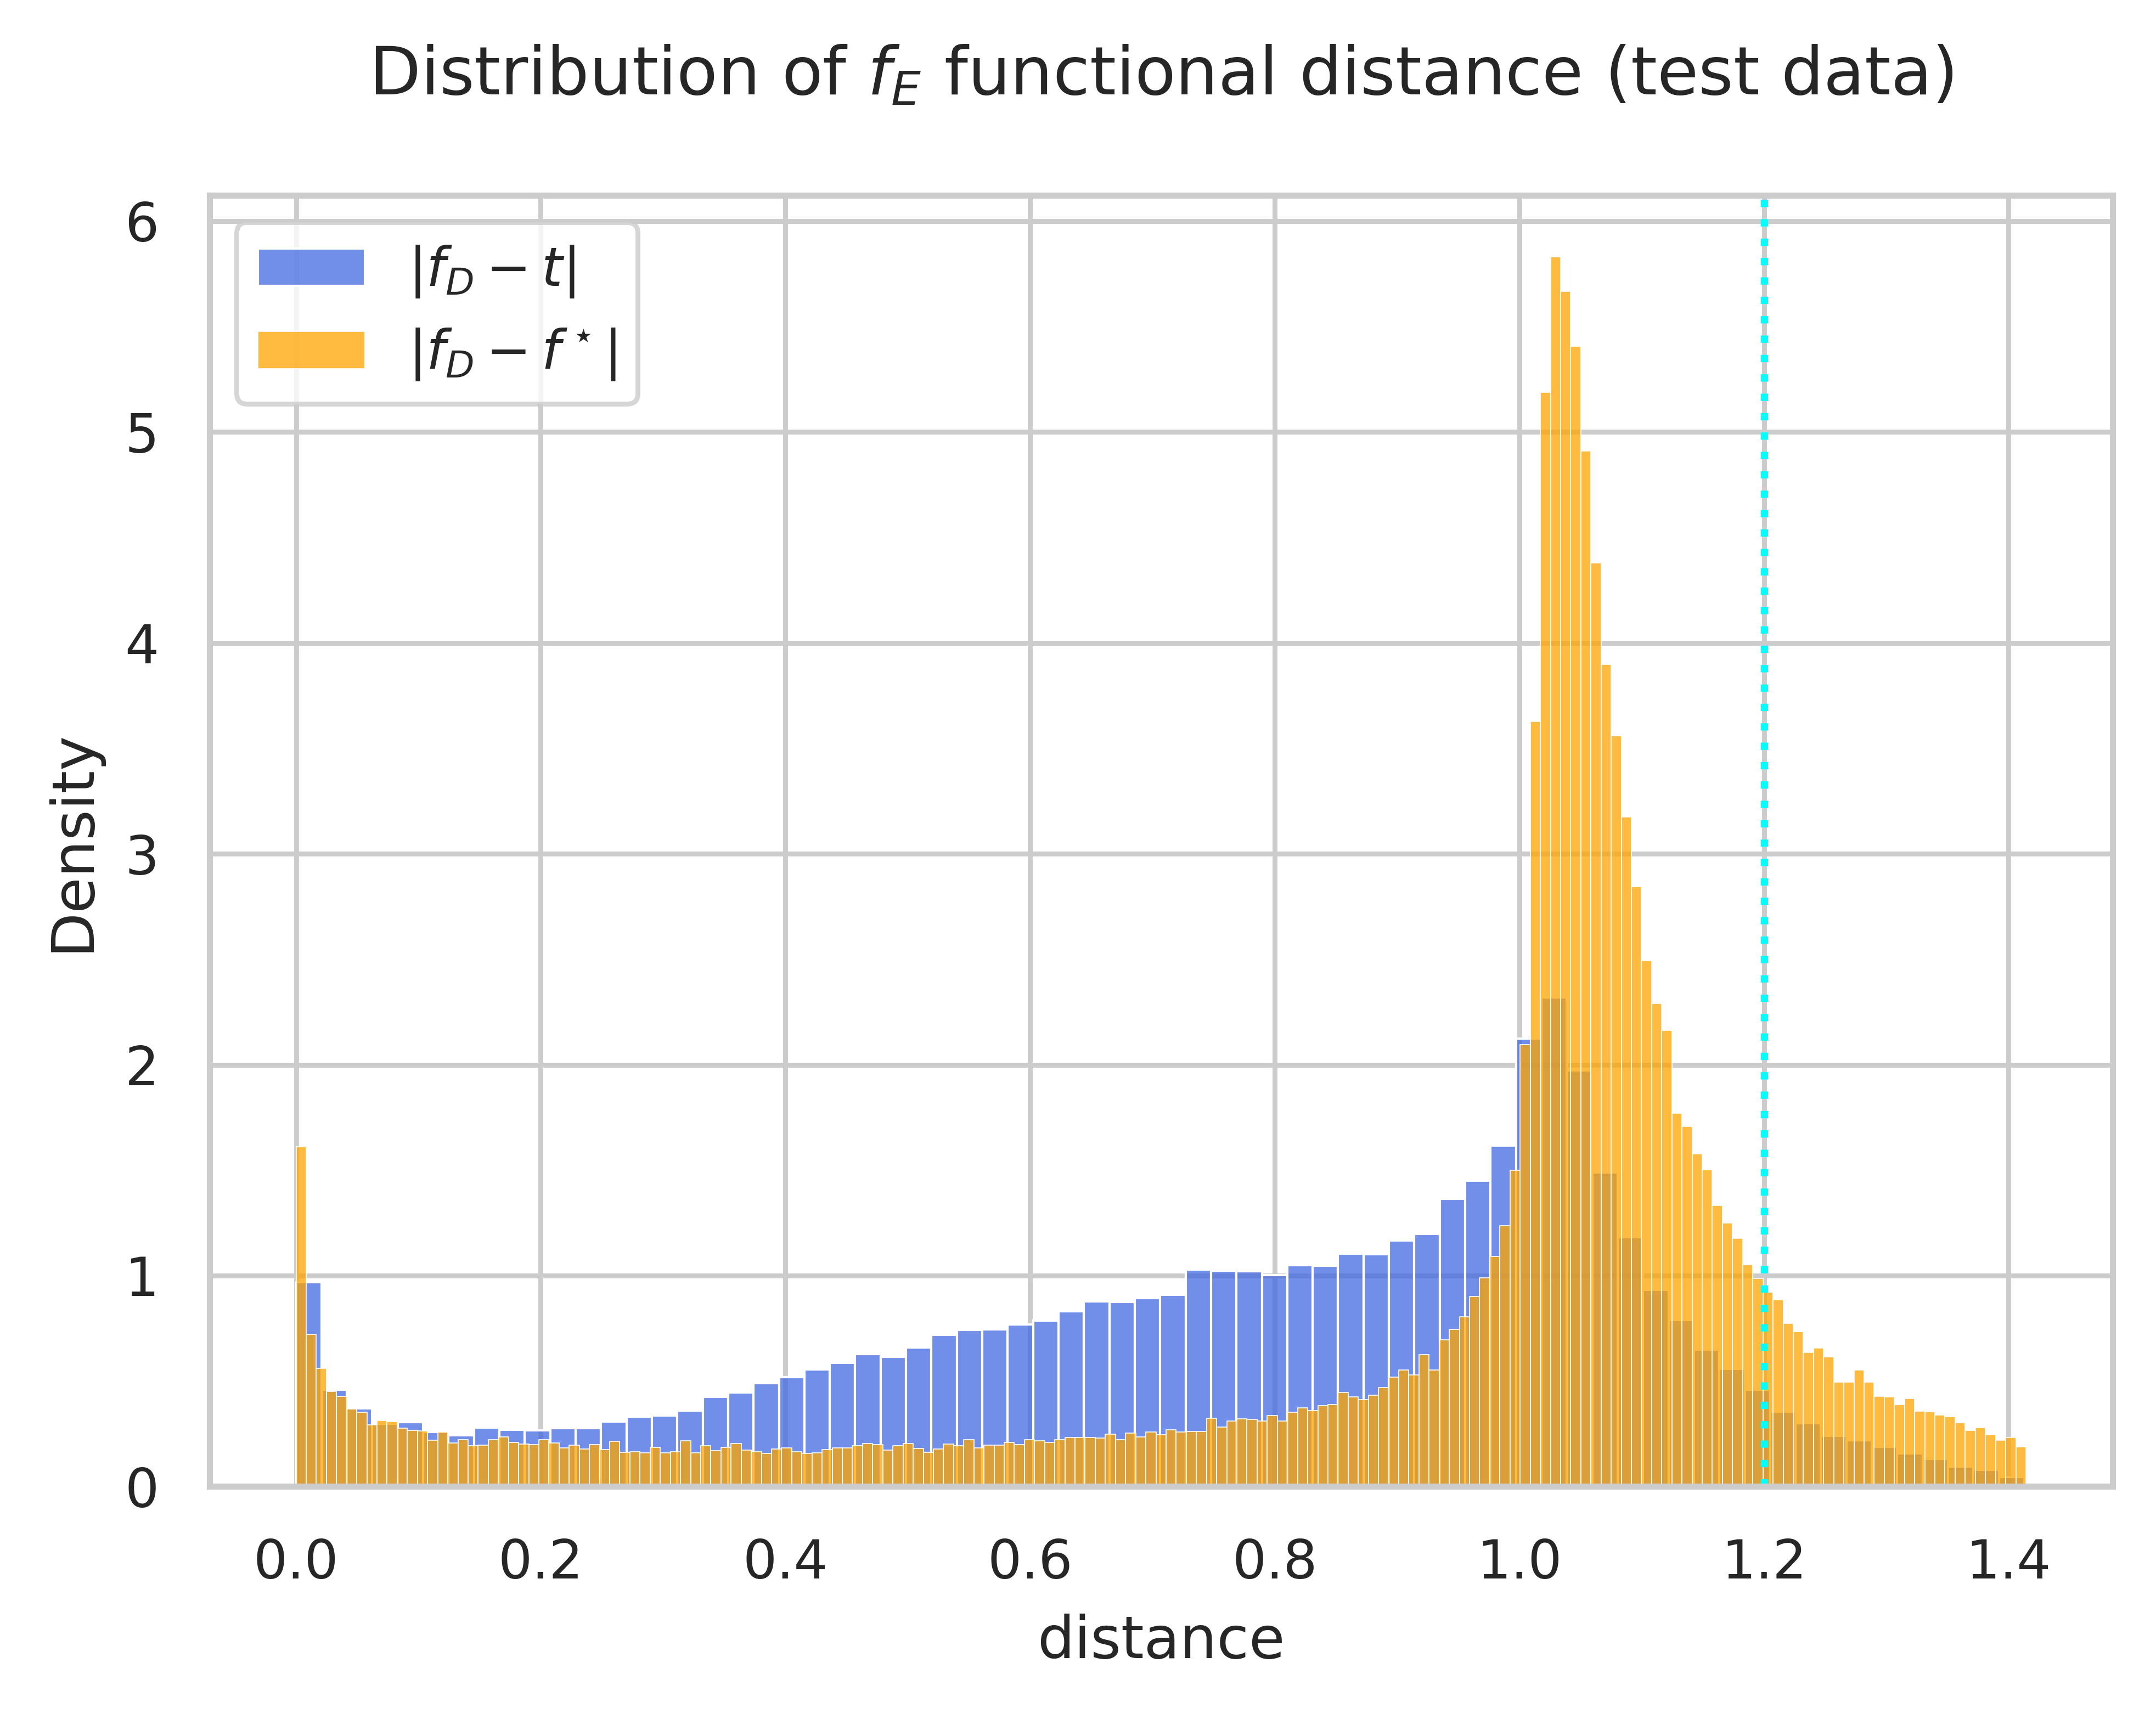

In [56]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,4), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']

    _df = res_df.loc[res_df['alpha']==1]

    _df1 = _df.loc[_df['teacher']==True]
    sns.histplot(_df1, x="distance", ax=ax, color=colors[0], label="train", stat="density")
    
    _df2 = _df.loc[_df['teacher']==False]
    sns.histplot(_df2, x="distance", ax=ax, color=colors[1], label="test", stat="density")

    ax.set_title(r"Distribution of $f_E$ functional distance (test data)", fontsize=11, y=1.05)
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, [r'$|f_D - t|$',r'$|f_D - f^\star|$'], title="", ncol=1, loc="upper left")

    ax.axvline(1.20, ls=':', color='aqua')

    
    plt.tight_layout()


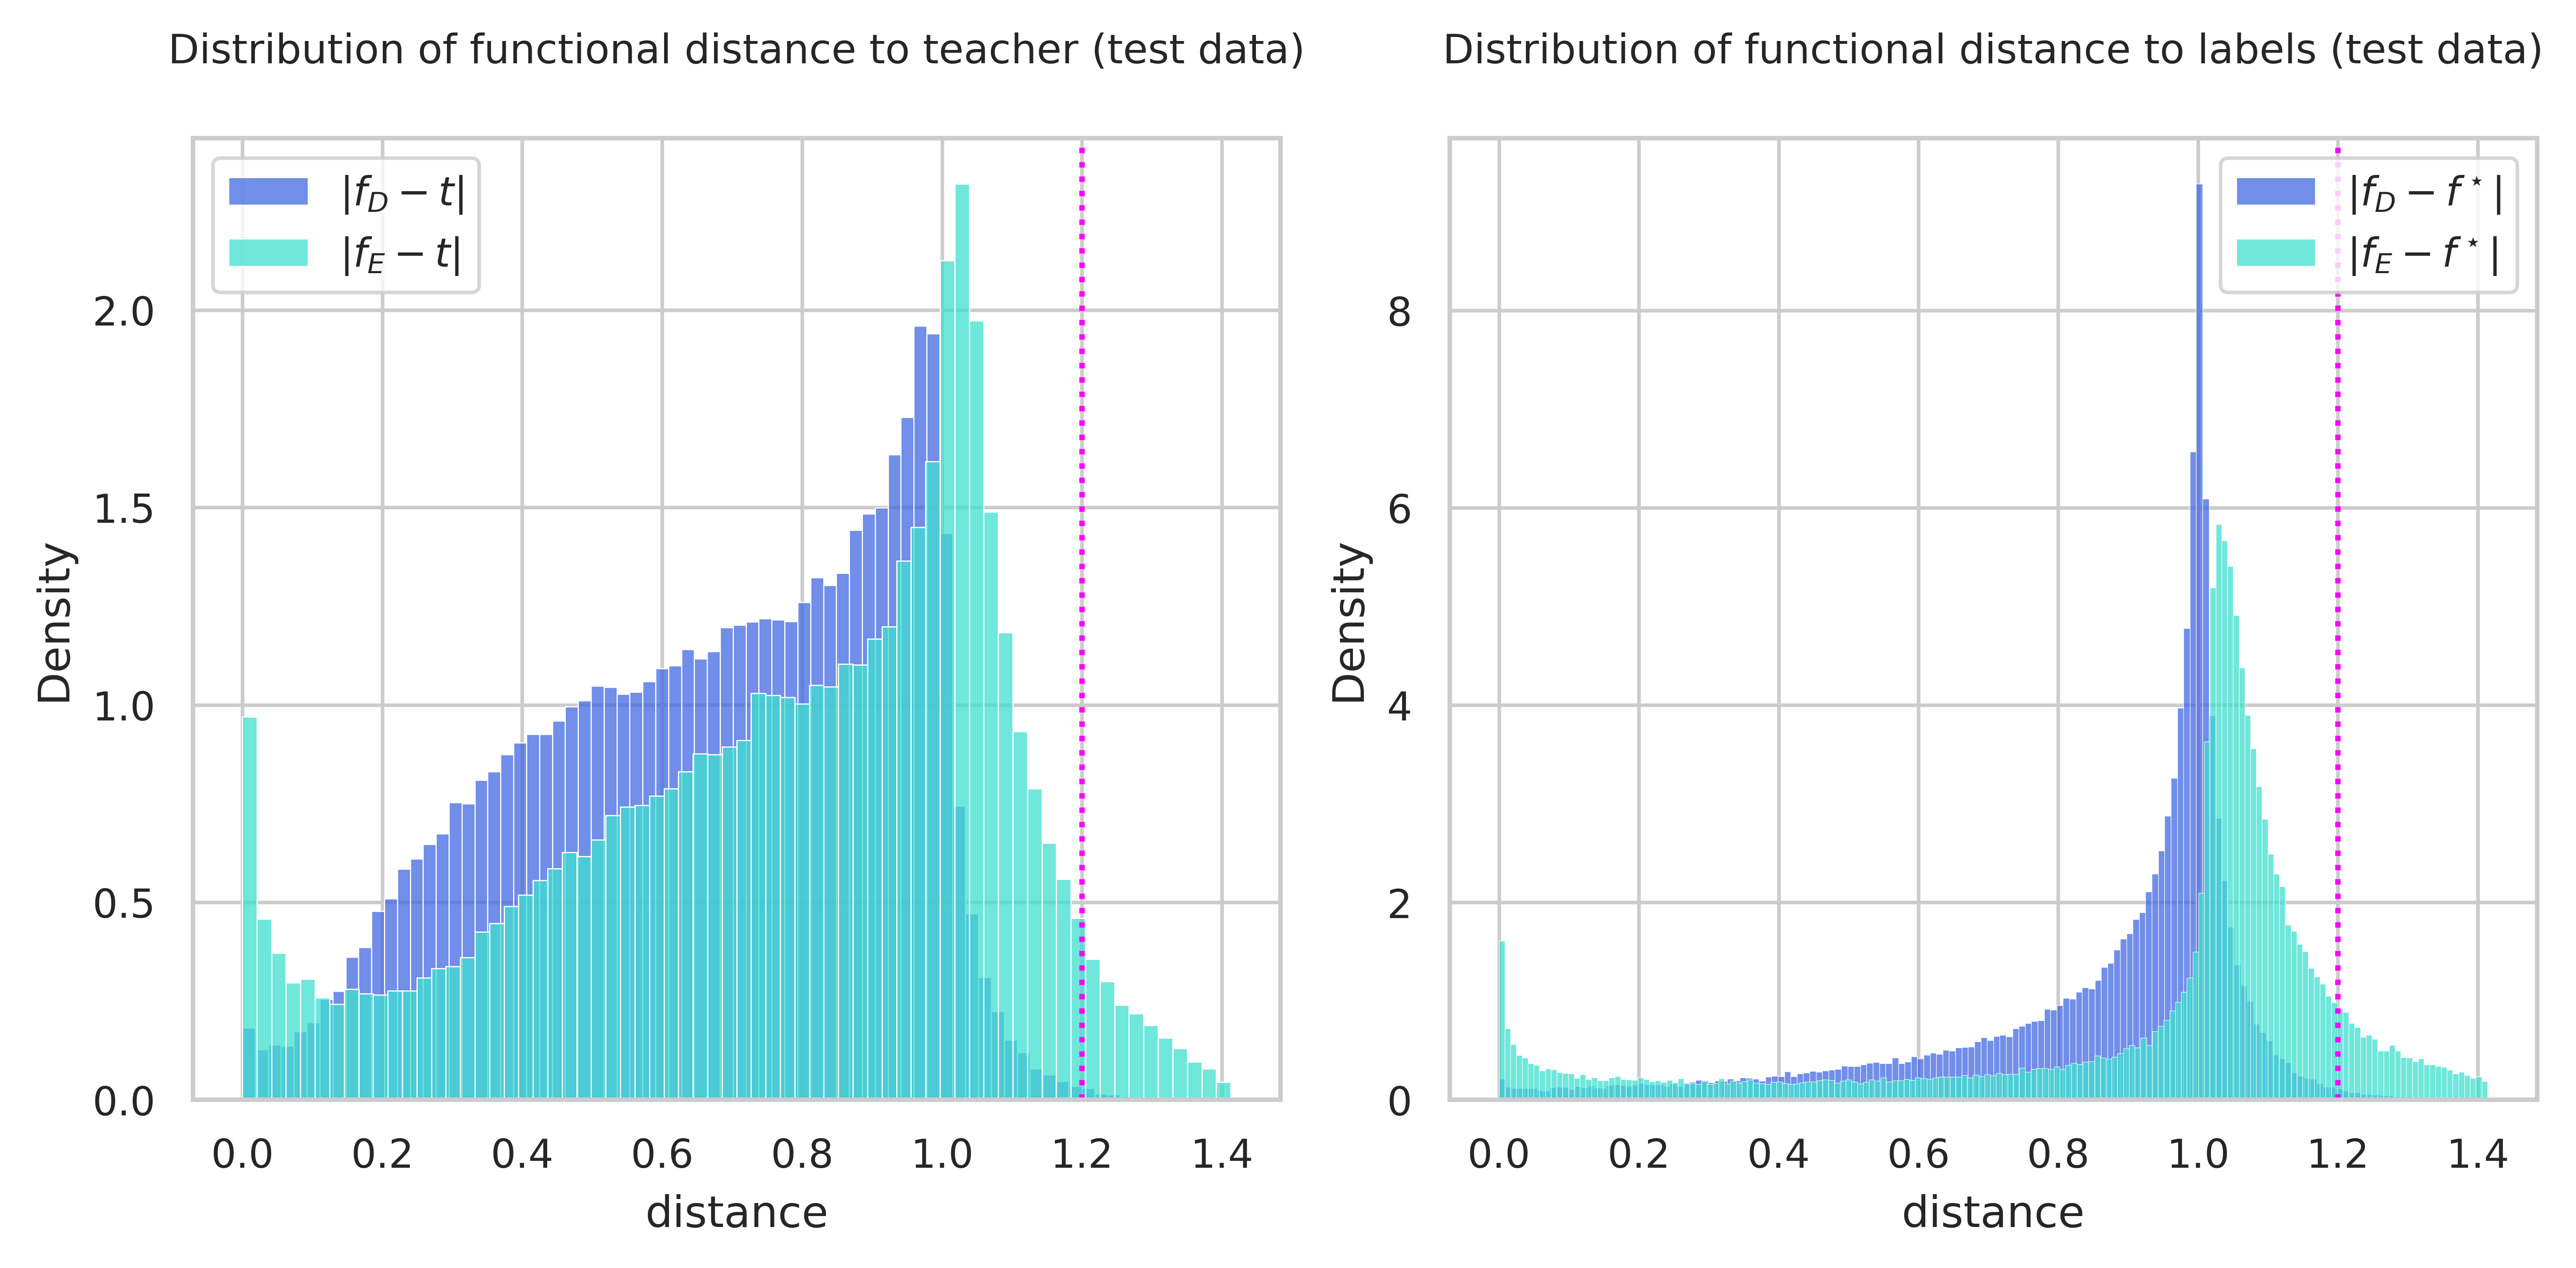

In [59]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=False, dpi=800)
    colors = ['royalblue','turquoise','dimgray']

    # first plot ---------------------------
    _df = res_df.loc[res_df['teacher']==True]

    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[0], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[0], color=colors[1], label=r"$f_E$", stat="density")

    ax[0].set_title(r"Distribution of functional distance to teacher (test data)", fontsize=9, y=1.05)
    
    ax[0].axvline(1.20, ls=':', color='magenta')

    # second plot ---------------------------
    _df = res_df.loc[res_df['teacher']==False]

    _df1 = _df.loc[_df['alpha']==0]
    sns.histplot(_df1, x="distance", ax=ax[1], color=colors[0], label=r"$f_D$", stat="density")
    
    _df2 = _df.loc[_df['alpha']==1]
    sns.histplot(_df2, x="distance", ax=ax[1], color=colors[1], label=r"$f_E$", stat="density")

    ax[1].set_title(r"Distribution of functional distance to labels (test data)", fontsize=9, y=1.05)
    
    ax[1].axvline(1.20, ls=':', color='magenta')

    # refinements ---------------------------
    h, _ = ax[0].get_legend_handles_labels()
    ax[0].legend(h, [r'$|f_D - t|$',r'$|f_E - t|$'], title="", ncol=1, loc="upper left")
    ax[1].legend(h, [r'$|f_D - f^\star|$',r'$|f_E - f^\star|$'], title="", ncol=1, loc="upper right")

    plt.tight_layout()
